In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from BayDS.lib.io import *
from BayDS.lib.training import *
from BayDS.lib.selection import *
pd.options.display.max_columns = None

In [3]:
initial_data = pd.read_pickle('./FE/initial_data.pkl')
pos_idx = initial_data[initial_data['goal1']==1].index
neg_idx = initial_data[initial_data['goal1']==0].index


In [144]:
u0 = 'a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52'
u1 = 'ddc18cda8a695df074d865c6a8e8775250fe8f8ea8fc4b490a52eaa254bf565a'
u2 = 'fbb571e6d32ed07b40ad806f8ca910423226f89a124b117c22c5878685fdea1f'
u3 = 'ab31cbff645cf74052284e1e91e6b2f1d40a382d480efefacbea09544bcf9c95'
ddt = initial_data [initial_data['userid']==u3].sort_values('field4')

In [124]:
initial_data [ initial_data.field6>100]['userid'].value_counts()

ddc18cda8a695df074d865c6a8e8775250fe8f8ea8fc4b490a52eaa254bf565a    4
fbb571e6d32ed07b40ad806f8ca910423226f89a124b117c22c5878685fdea1f    3
ab31cbff645cf74052284e1e91e6b2f1d40a382d480efefacbea09544bcf9c95    2
e1a0630e8b667925bc444851bfd58129bf3d54fc02a0d9427a82093478b78244    2
32c47e8c6a57622ecb0b4b388b149e2dc754a4c85f2d42ea9a7356aaef3e466e    2
                                                                   ..
aac3d55cb4f2e77ce1962531b5205fd4192fabf587d0e441c88634a5d431a997    0
aac3dba3e56ab1b4ba5a0522b0a5c6f844e97e1fcf8f335a0e53f8c3511f62f5    0
aac3f6c36ca90eee22c108f98355d2fff64ad29a8b2e0bbec059262d1505c1f7    0
aac40aca1d136cf4062358a0e46c4226eb6e0df4991ae6f264ae68266b7dba47    0
0000190f971ec1c342853c517f2dea7200d49524f1936aee4ad0bb2990fc45ec    0
Name: userid, Length: 378449, dtype: int64

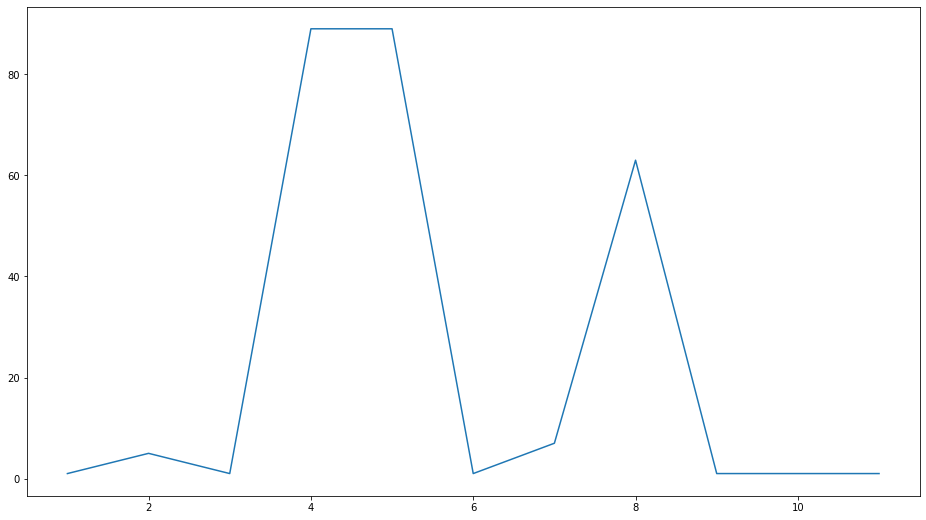

In [145]:
plt.figure(figsize=(16,9))
plt.plot(ddt.field4, ddt['field25'])
# ax1 = plt.gca().twinx()
# ax1.plot(ddt.field4, ddt['field17'],c='r',alpha=0.5)

In [139]:
initial_data.field25.value_counts()

1      531531
18      24667
2       10357
21       5487
22       4839
        ...  
128         1
160         1
158         1
155         1
193         1
Name: field25, Length: 194, dtype: int64

In [146]:
for col in initial_data.columns:
    if initial_data[col].dtype.name in ('category','object'):
        continue
    test_feature = initial_data[col] / initial_data.groupby('field25')[col].transform('mean')
    initial_data['test_feature'] = test_feature

    train = initial_data[initial_data['goal1']>=0]
    scores = []
    for goal in ['goal1', 'goal21', 'goal22', 'goal23', 'goal24', 'goal25']:
        x = individual_gini('test_feature',train,train[goal],-1) -  individual_gini(col,train,train[goal],-1)
        scores.append(x)
    print(col, scores)


field0 [0.0, -0.10000000000000142, 0.0, 0.0, 0.0, -0.4000000000000008]
field1 [-0.9000000000000021, -5.800000000000004, -2.3999999999999986, -2.6000000000000014, -0.3999999999999986, 4.500000000000002]
field2 [7.6999999999999975, 6.5, 2.700000000000001, 0.20000000000000018, 0.5999999999999996, 2.3999999999999986]
field3 [6.8, 5.999999999999999, 1.8000000000000007, 0.3000000000000007, 1.0, 4.6]
field4 [3.8, 3.5000000000000036, 0.7000000000000028, 0.5, 2.099999999999998, 8.7]
field5 [4.0, 4.600000000000001, 1.8999999999999986, 0.6999999999999997, 2.4000000000000004, 8.100000000000001]
field6 [-0.29999999999999893, -0.1999999999999993, -0.09999999999999964, 0.10000000000000009, -0.2999999999999998, -0.1999999999999993]
field7 [0.5999999999999979, 0.7999999999999989, 0.39999999999999947, 0.0, 0.40000000000000013, 0.10000000000000009]
field8 [6.800000000000002, 5.0, 3.5, 2.1000000000000014, 3.8000000000000007, 10.7]
field9 [0.2, 1.0, 0.0, 0.0, 0.0, 0.0]
field10 [10.299999999999999, 3.600000

In [5]:
def shift(df,name='next', feature='field0', val=-1):
    shift_agg = lambda x: x.sort_index().shift(val)
    ddt_index=df.loc[:,['userid','field4',feature]].reset_index().set_index(['userid','field4'])
    ddt_index.loc[:,name] = ddt_index[feature].agg(shift_agg)
    return ddt_index.set_index('orderid')[name]
    

### Days to next order

In [6]:
initial_data['daysToNextOrder'] = shift(initial_data)

In [7]:
initial_data[initial_data['daysToNextOrder'].isna()]

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,...,field0bin,field6bin,field13bin,field16bin,field17bin,field22bin,field25bin,price1bin,price2bin,daysToNextOrder
orderid,,,,,,,,,,,,,,,,,,,,,
1081409,ffffec088571b537c70f463641966df601eaf356a40ad2...,0,-0.471365392208099,8,8,1,1,0,1,1,...,0,0,0,0,0,0,0,2,2,NaN


In [20]:
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextOrder',train,train.goal1,-1)

5.7

In [29]:
initial_data['daysToNextOrder_dividedBy_field16'] = initial_data['daysToNextOrder'] /initial_data['field16'] 
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextOrder_dividedBy_field16',train,train.goal1,-1)

17.0

### Days to next flight

In [24]:
initial_data['daysToNextFlight'] = shift(initial_data) + shift(initial_data, feature='field16') 

In [25]:
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextFlight',train,train.goal1,-1)

0.2

In [28]:
initial_data['daysToNextFlight_dividedBy_field16'] = initial_data['daysToNextFlight'] /initial_data['field16'] 
train = initial_data[initial_data['goal1']>=0]
individual_gini('daysToNextFlight_dividedBy_field16',train,train.goal1,-1)

18.3

In [ ]:
#date of next flight - date of this flight

In [ ]:
#date of this flight - date of prev flight

In [109]:
initial_data [initial_data['userid']=='a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52'] [['field0','field4','daysToNextOrder','field16','goal1']].sort_values('field4').iloc[:20]

,field0,field4,daysToNextOrder,field16,goal1
orderid,,,,,
1162877,0,1,0.0,1,0
1125446,0,2,0.0,1,0
1039421,0,3,16.0,1,0
1174386,16,4,0.0,4,0
1083155,0,5,1.0,5,1
1186621,1,6,0.0,5,0
1102930,0,7,3.0,8,0
1189031,3,8,0.0,3,0
1177676,0,9,0.0,4,0


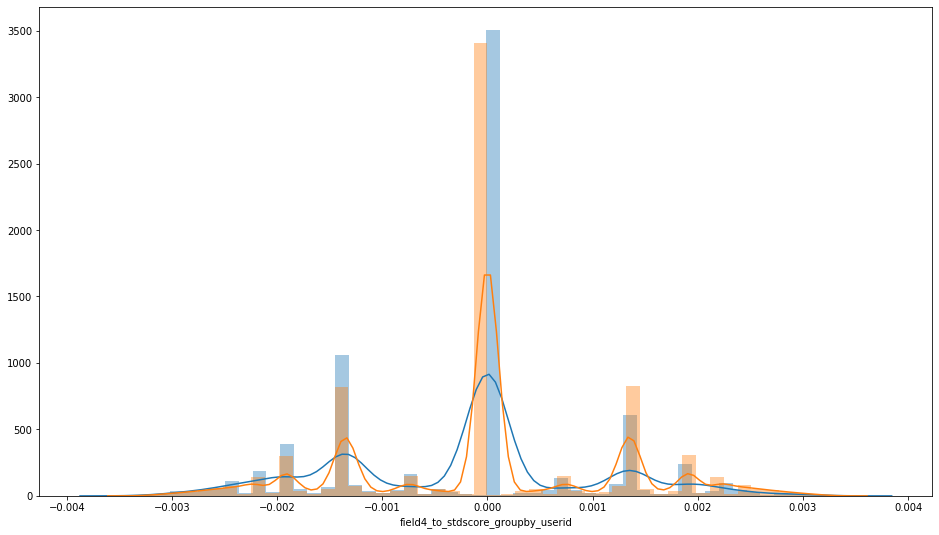

In [37]:
f = data['field4_to_stdscore_groupby_userid'].compute()
df = pd.DataFrame(index=initial_data[initial_data.goal1>=0].index)
df['goal'] = initial_data.goal1
df['feature'] = f
plt.figure(figsize=(16,9))
# sns.scatterplot(x='feature', y='goal', data=df)
sns.distplot(f.loc[pos_idx],bins=50)
sns.distplot(f.loc[neg_idx],bins=50)
# plt.yscale('log')

In [ ]:
f = data['field4_to_stdscore_groupby_userid'].compute()
df = pd.DataFrame(index=initial_data[initial_data.goal1>=0].index)
df['goal'] = initial_data.goal1
df['feature'] = f
plt.figure(figsize=(16,9))
# sns.scatterplot(x='feature', y='goal', data=df)
sns.distplot(f.loc[pos_idx],bins=50)
sns.distplot(f.loc[neg_idx],bins=50)
# plt.yscale('log')